Lets add enable langsmith so we visualize the control flow of our graph

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "init-context-graph"

In [1]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "init-context-graph"

Now lets define a helper method to initialize our config and state

In [2]:
from utilities.file_management import read_files
from utilities.generate_tree_graph import generate_package_list

from graphs.config_provider import get_config

def init_state():
    project_root = get_config()["project-root"]
    summary_path = Path(get_config()["project-root"]) / "summary.md"
    if summary_path.exists():
        existing_summary = read_files("summary.md", project_root)
    else:
        existing_summary = ""
    project_structure = generate_package_list(get_config()["project-root"])
    return {"messages": [], 
            "project_root": get_config()["project-root"],
            "files_to_read": [], 
            "file_contents": [], 
            "cli_input": "", 
            "summary": existing_summary, 
            "project_structure": project_structure}

✅ Loaded config from: /Users/justin.mascotto/Projects/ASTparser/code-gen/config.yaml


Now we will define our graph

In [3]:
# Human approved file write graph

import json
from collections import deque
from typing import Literal

from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END, START
from langgraph.types import Command, interrupt
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from graphs.llm_provider import get_llm_manager
from graphs.tools.read_file_tool import read_file
from graphs.tools.vector_store_tool import retrieve_relevant_code

class MainState(MessagesState):
    cli_input: str = ""
    files_to_read: list[str] = []
    project_structure: str = ""
    project_root: str
    summary: str = ""
    tasks: deque[str]
    current_task: str
    
def human_approval_node(state: MainState):
    """Human node with validation."""
    question = "Would you like to write the generated file? (y/n)"

    while True:
        answer = interrupt(question)

        # Validate answer, if the answer isn't valid ask for input again.
        if answer.strip().lower() not in {"yes", "y", "no", "n"}:
            question = f"'{answer} is not a valid answer. "
            answer = None
            continue
        else:
            # If the answer is valid, we can proceed.
            break

    return {
        "cli_input": answer
    }

def write_file_node(state: MainState):
    # Find the latest AIMessage
    last_ai_msg = next((msg for msg in reversed(state["messages"]) if isinstance(msg, AIMessage)), None)

    if not last_ai_msg:
        print("No AIMessage found in state. Cannot write file.")
        return state

    try:
        # Extract JSON payload from AIMessage content
        file_info = json.loads(last_ai_msg.content)
        file_name = file_info["file_name"]
        file_content = file_info["file_content"]
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Failed to parse file info: {e}")
        return state

    # Construct full path
    full_path = os.path.join(state["project_root"], file_name)

    # Ensure parent directories exist
    os.makedirs(os.path.dirname(full_path), exist_ok=True)

    # Write the file
    with open(full_path, "w", encoding="utf-8") as f:
        f.write(file_content)

    print(f"✅ File written to {full_path}")
    return state

# evaluate the state update from humal_approval_node
def router(state: MainState) -> Command[Literal["write_file","__end__"]]:
    if state["cli_input"].strip().lower() in {"yes","y"}:
        return Command(goto="write_file")
    else:
        return Command(goto=END)
    

def build_write_file_graph():
    builder = StateGraph(MainState)
    builder.add_node("human_approval", human_approval_node)
    builder.add_node("router", router)
    builder.add_node("write_file",write_file_node)

    builder.add_edge(START,"human_approval")
    builder.add_edge("human_approval","router")
    builder.add_edge("write_file", END)
    return builder
    
    

/Users/justin.mascotto/Projects/ASTparser/code-gen/utilities/retrieval_manager.py:26: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_model = HuggingFaceEmbeddings(
/Users/justin.mascotto/Projects/ASTparser/code-gen/code-gen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/justin.mascotto/Projects/ASTparser/code-gen/utilities/retrieval_manager.py:31: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed 

In [ ]:
To test the above graph you may run the following

In [ ]:
from langchain_core.messages import AIMessage
import json

memory = MemorySaver()
test_graph = build_write_file_graph().compile(checkpointer=memory)

test_state = init_state()
test_state["messages"] = [AIMessage(json.dumps({
    "file_name": "audit-log-api/src/test/kotlin/com/w2g/auditlog/api/web/AuditLogEntryHandlerSpec.kt",
    "file_content": 
            (
                "package com.w2g.auditlog.api.web\n\n"
                "import io.kotest.core.spec.style.DescribeSpec\n"
                "import io.kotest.matchers.shouldBe\n"
                "class AuditLogEntryHandlerSpec : DescribeSpec({\n"
                "    describe(\"AuditLogEntryHandler\") {\n"
                "        it(\"hello\") {\n"
                "1 shouldBe 2\n}}})"
            )
        
}))]
test_thread = {
    "recursion_limit": 100,
    "configurable": {
        "thread_id": "3",
        "project-root": get_config()["project-root"]
    }
}
for test_event in test_graph.stream(test_state, test_thread, stream_mode="values"):
    if "messages" in test_event and len(test_event["messages"]) > 0:
        test_event["messages"][-1].pretty_print()

if test_event["__interrupt__"]:
    print("\n\n" + test_event["__interrupt__"][0].value)
    command_resume_input = input(">>>")
    for test_event in test_graph.stream(Command(resume=command_resume_input), test_thread, stream_mode="values"):
        if "messages" in test_event and len(test_event["messages"]) > 0:
            test_event["messages"][-1].pretty_print()

In [15]:
import json
from collections import deque
from typing import Literal

from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from graphs.llm_provider import get_llm_manager
from graphs.tools.read_file_tool import read_file
from graphs.tools.vector_store_tool import retrieve_relevant_code

planner_node_system_prompt="""
You are a senior software engineer. It is your job to interpret any question being asked and decompose 
it into smaller more focused tasks. You should only respond in json format. For instance, if you were 
asked "Create a persistence layer for model X with basic CRUD operations", you might respond with 
'{{"tasks":["Create DAO class for model X with basic CRUD operations","Create unit test for the DAO class"]}}'

Limit the number of tasks to 1.

Here is a summary of the project for context:
{summary}
"""
#If you are initializing data model objects in your code where the 
#class definition exists in the project structure, you should read them in order to accurately 
#construct them in your generated code.
executor_prompt="""
Evaluate your given task with the provided project structure and summary. If you're going to use the retrieve_relevant_code tool, 
make sure to include the technology names and keywords and non domain-speific tooling class names and methods in your query. 
Do not try to read files that are not in the project structure. 
Any notes about the code generated should be added in comments in the code and your output should be strictly 
code that can compile or run as is. Your output should be in json form so it can be easily parsed and saved to disk.
{{ "file_content": "<CODE_CONTENT>", "file_name": "<FILE_NAME>" }}
There should be no other text besides the json in your response.

You have a budget of 3 tool calls to read_file.
You have a budget of 3 tool calls to retrieve_relevant_code. 
Do not exceed these limits!

Dont take too long, your answer is needed promptly even if its not as accurate as you'd like.

Structure:
{project_structure}

Summary:
{summary}
"""

tools = [read_file,retrieve_relevant_code]
llm_with_tools = get_llm_manager().get_llm().bind_tools(tools)

def planner_node(state: MainState):
    system_msg = planner_node_system_prompt.format(summary=state["summary"])
    response = get_llm_manager().get_llm().invoke([system_msg,HumanMessage(content=state["cli_input"])])
    tasks = json.loads(response.content)["tasks"]
    return {"messages":[response], "tasks":deque(tasks)}

def filter_messages(state: MessagesState):
    """
    Remove all messages that are:
    - AI messages that include tool calls
    - Tool response messages
    """
    messages = state["messages"]

    delete_messages = [
        RemoveMessage(id=m.id)
        for m in messages
        if (
            # tool call message from AI
            getattr(m, "tool_calls", None)
                and isinstance(m.tool_calls, list)
                and len(m.tool_calls) > 0
           )
           or (
               # tool response message
                getattr(m, "type", None) == "tool"
           )
    ]
    return {"messages": delete_messages}

def continue_to_task_node(state: MainState) -> Command[Literal["executor", "__end__"]]:
    tasks: deque[str] = state["tasks"]
    returnCommand = Command(update={"current_task": ""}, goto=END)
    if not tasks or len(tasks) == 0:                       # nothing left
        return returnCommand

    next_task = tasks.popleft()
    if next_task == "":
        return returnCommand
    return Command(update={"current_task": next_task}, goto="executor")

def executor_node(state: MainState):
    response = llm_with_tools.invoke( state["messages"] + [SystemMessage(executor_prompt.format(project_structure=state["project_structure"], summary=state["summary"])), HumanMessage(content=state["current_task"])])
    return {"messages": [response]}

tool_node = ToolNode(tools)

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "should_write_file"

def build_graph():
    builder = StateGraph(MainState)
    builder.add_node("planner", planner_node)
    builder.add_node("filter_messages", filter_messages)
    builder.add_node("continue_to_task", continue_to_task_node)

    # Register the map_node (wraps a function that handles a single task)
    builder.add_node("executor", executor_node)
    builder.add_node("tools", tool_node)
    builder.add_node("should_write_file",build_write_file_graph().compile())

    builder.add_edge(START, "planner")
    builder.add_edge("planner", "filter_messages")
    builder.add_edge("filter_messages", "continue_to_task")
    builder.add_edge("should_write_file","filter_messages")
    # we dont need the below edge because we have it defined in the return hint from 
    # continue_to_task. see https://langchain-ai.github.io/langgraph/how-tos/graph-api/#combine-control-flow-and-state-updates-with-command
    #builder.add_edge("continue_to_task", "executor")
    #builder.add_edge("continue_to_task", END)

    builder.add_conditional_edges("executor", should_continue, ["tools", "should_write_file"])
    builder.add_edge("tools", "executor")

    return builder

Lets compile our graph and view it visually

In [16]:
from pathlib import Path

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

from graphs.config_provider import get_config

memory = MemorySaver()
rag_graph = build_graph().compile(checkpointer=memory)

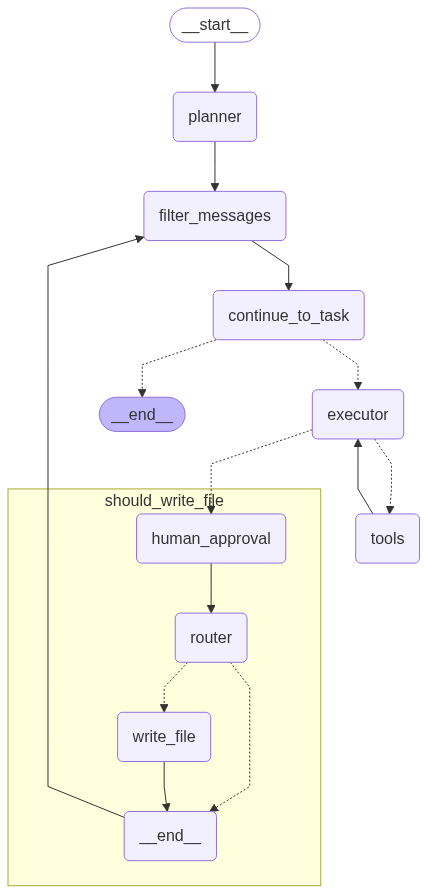

In [21]:
display(Image(rag_graph.get_graph(xray=True).draw_mermaid_png()))

Now we can invoke our graph

In [17]:
from pathlib import Path

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

from graphs.config_provider import get_config

memory = MemorySaver()
rag_graph = build_graph().compile(checkpointer=memory)

state = init_state()
thread = {
    "recursion_limit": 100,
    "configurable": {
        "thread_id": "3",
        "project-root": get_config()["project-root"]
    }
}
print("How can I help you?")
state["cli_input"] = input(">>>")

for event in rag_graph.stream(state, thread, stream_mode="values"):
    if "messages" in event and len(event["messages"]) > 0:
        event["messages"][-1].pretty_print()


    

        #Can you help me write a test for the AuditLogEntryHandler.searchAuditLogsAdmin method?


How can I help you?


>>> Can you help me write a test for the AuditLogEntryHandler.searchAuditLogsAdmin method?


================================== Ai Message ==================================

{"tasks":["Write a unit test for the AuditLogEntryHandler.searchAuditLogsAdmin method that verifies it correctly processes admin search requests, applies filters, and returns the expected response"]}
================================== Ai Message ==================================

{"tasks":["Write a unit test for the AuditLogEntryHandler.searchAuditLogsAdmin method that verifies it correctly processes admin search requests, applies filters, and returns the expected response"]}
================================== Ai Message ==================================

{"tasks":["Write a unit test for the AuditLogEntryHandler.searchAuditLogsAdmin method that verifies it correctly processes admin search requests, applies filters, and returns the expected response"]}
================================== Ai Message ==================================

[{'text': "I'll help you write a unit test for the AuditLogEntryHandler.

In [18]:
if "__interrupt__" in event:
    print("\n\n" + event["__interrupt__"][0].value)
    command_resume_input = input(">>>")
    for event in rag_graph.stream(Command(resume=command_resume_input), thread, stream_mode="values"):
        if "messages" in event and len(event["messages"]) > 0:
            event["messages"][-1].pretty_print()



Would you like to write the generated file? (y/n)


>>> Y


================================== Ai Message ==================================

{"file_content":"package com.w2g.auditlog.api.web\n\nimport com.w2g.api.request.parseSearchQueryParams\nimport com.w2g.api.response.jsonBodyWithCursorAndAwait\nimport com.w2g.audit.log.common.dao.AuditLogEntryDaoSettings\nimport com.w2g.audit.log.common.entity.AuditLogEntry\nimport com.w2g.audit.log.common.mapper.AuditLogEntryMapper\nimport com.w2g.audit.log.dto.AuditLogEntryDto\nimport com.w2g.auditlog.api.service.AuditLogEntryService\nimport com.w2g.common.spring.testing.HandlerSpec\nimport com.w2g.core.common.CursorChunk\nimport com.w2g.core.common.search.SearchFilter\nimport com.w2g.core.common.search.SearchOperator\nimport com.w2g.core.common.search.SearchQueryParams\nimport io.mockk.*\nimport org.springframework.http.HttpStatus\nimport org.springframework.web.reactive.function.server.ServerRequest\nimport org.springframework.web.reactive.function.server.ServerResponse\nimport java.time.Instant\n\ncl

In [81]:
from langchain_core.messages import AIMessage
import json

memory = MemorySaver()
test_graph = build_write_file_graph().compile(checkpointer=memory)

test_state = init_state()
test_state["messages"] = [AIMessage(json.dumps({
    "file_name": "audit-log-api/src/test/kotlin/com/w2g/auditlog/api/web/AuditLogEntryHandlerSpec.kt",
    "file_content": 
            (
                "package com.w2g.auditlog.api.web\n\n"
                "import io.kotest.core.spec.style.DescribeSpec\n"
                "import io.kotest.matchers.shouldBe\n"
                "class AuditLogEntryHandlerSpec : DescribeSpec({\n"
                "    describe(\"AuditLogEntryHandler\") {\n"
                "        it(\"hello\") {\n"
                "1 shouldBe 2\n}}})"
            )
        
}))]
test_thread = {
    "recursion_limit": 100,
    "configurable": {
        "thread_id": "3",
        "project-root": get_config()["project-root"]
    }
}
for test_event in test_graph.stream(test_state, test_thread, stream_mode="values"):
    if "messages" in test_event and len(test_event["messages"]) > 0:
        test_event["messages"][-1].pretty_print()

if test_event["__interrupt__"]:
    print("\n\n" + test_event["__interrupt__"][0].value)
    command_resume_input = input(">>>")
    for test_event in test_graph.stream(Command(resume=command_resume_input), test_thread, stream_mode="values"):
        if "messages" in test_event and len(test_event["messages"]) > 0:
            test_event["messages"][-1].pretty_print()


================================== Ai Message ==================================

{"file_name": "audit-log-api/src/test/kotlin/com/w2g/auditlog/api/web/AuditLogEntryHandlerSpec.kt", "file_content": "package com.w2g.auditlog.api.web\n\nimport io.kotest.core.spec.style.DescribeSpec\nimport io.kotest.matchers.shouldBe\nclass AuditLogEntryHandlerSpec : DescribeSpec({\n    describe(\"AuditLogEntryHandler\") {\n        it(\"hello\") {\n1 shouldBe 2\n}}})"}


Would you like to write the generated file? (y/n)


>>> Y


================================== Ai Message ==================================

{"file_name": "audit-log-api/src/test/kotlin/com/w2g/auditlog/api/web/AuditLogEntryHandlerSpec.kt", "file_content": "package com.w2g.auditlog.api.web\n\nimport io.kotest.core.spec.style.DescribeSpec\nimport io.kotest.matchers.shouldBe\nclass AuditLogEntryHandlerSpec : DescribeSpec({\n    describe(\"AuditLogEntryHandler\") {\n        it(\"hello\") {\n1 shouldBe 2\n}}})"}
================================== Ai Message ==================================

{"file_name": "audit-log-api/src/test/kotlin/com/w2g/auditlog/api/web/AuditLogEntryHandlerSpec.kt", "file_content": "package com.w2g.auditlog.api.web\n\nimport io.kotest.core.spec.style.DescribeSpec\nimport io.kotest.matchers.shouldBe\nclass AuditLogEntryHandlerSpec : DescribeSpec({\n    describe(\"AuditLogEntryHandler\") {\n        it(\"hello\") {\n1 shouldBe 2\n}}})"}
✅ File written to /Users/justin.mascotto/Projects/audit-log-service/audit-log-api/src/test

In [44]:
print(test_event)
command = Command(resume="yes")
for test_event in test_graph.stream(command, test_thread, stream_mode="values"):
    if "messages" in test_event and len(test_event["messages"]) > 0:
        test_event["messages"][-1].pretty_print()

{'__interrupt__': (Interrupt(value='Would you like to write the generated file? (y/n)', resumable=True, ns=['human_approval:63392f02-39e2-d9b6-98b6-465ecc40bcc3']),)}
You wrote the file


In [39]:
interrupt = event["__interrupt__"][0]
print(interrupt.value)

interrupt_ns = interrupt.ns[0]

print(interrupt_ns)

resume_state = rag_graph.get_state(thread)

command = Command(resume="yes")

for event in rag_graph.stream(command, thread, stream_mode="values"):
    if "messages" in event and len(event["messages"]) > 0:
        event["messages"][-1].pretty_print()



KeyError: '__interrupt__'

In [29]:
rag_graph.get_state(thread)

StateSnapshot(values={'messages': [AIMessage(content='{"tasks":["Create a unit test for the AuditLogEntryHandler.searchAuditLogsAdmin method that verifies proper filtering, pagination, and authorization for admin-level audit log searches"]}', additional_kwargs={}, response_metadata={'id': 'msg_01SDJNodoPeL1rwMuhBuVhBR', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1193, 'output_tokens': 48, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run--5a2a1b0c-f3d7-409e-959c-8c7c49f13e32-0', usage_metadata={'input_tokens': 1193, 'output_tokens': 48, 'total_tokens': 1241, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), AIMessage(content=[{'text': "I'll help you create a unit test for the `AuditLogEntryHandler.searchAuditLogsAdmin` method. First, let's examine the existing handler class and any

In [ ]:
for event in rag_graph.stream(None, thread, stream_mode="values"):
    if "messages" in event and len(event["messages"]) > 0:
        event["messages"][-1].pretty_print()